# Loan Approval
Will my loan get approved?
We will use several machine learning models in order to predict the approval of a loan demand, depending on several variables.

The dataset is from Analytics Vidhya and is available at https://datahack.analyticsvidhya.com/contest/practice-problem-loan-prediction-iii/

First, if we're running this code on a new server, we need to make sure that Keras and Tensorboard are installed since we use these libraries for the Deep Neural Network model.

In [ ]:
!pip3 install keras
!pip3 install tensorboard

# 1. Data Preprocessing
For the first part of the Notebook, we will explore the dataset from Analytics Vidhya and prepare it for exploitation.

The goals of the data preprocessing are to:
- Import the dataset
- Select and clean the more relevant features
- Create variables ready to be exploited by our Machine Learning models

## 1.1 Import the dataset

Before preprocessing the data, we need to import the dataset within the Python kernel. We will then exclude the first column, the row id, which will not be relevant for our problem. Finally, we can reorder the columns to fit our needs better, and have a look at the dataset.

In [37]:
import pandas as pd
import numpy as np

dataset = pd.read_csv('data/loan_approval_dataset.csv')
dataset = dataset[['Gender','Married','Education','Self_Employed','Property_Area','Dependents','Credit_History',
                  'ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Loan_Status']]
dataset.iloc[:5,:]

,Gender,Married,Education,Self_Employed,Property_Area,Dependents,Credit_History,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Loan_Status
0,Male,No,Graduate,No,Urban,0,1.0,5849,0.0,NaN,360.0,Y
1,Male,Yes,Graduate,No,Rural,1,1.0,4583,1508.0,128.0,360.0,N
2,Male,Yes,Graduate,Yes,Urban,0,1.0,3000,0.0,66.0,360.0,Y
3,Male,Yes,Not Graduate,No,Urban,0,1.0,2583,2358.0,120.0,360.0,Y
4,Male,No,Graduate,No,Urban,0,1.0,6000,0.0,141.0,360.0,Y


## 1.2 Clean the features
We can now split the columns between the independent variables and the dependent variable, and clean the data:
- The fifth column 'Dependents' is treated as a string since it contains some values '3+'. We need to change these values to the int 3
- There are missing data on some rows

In [38]:

X = dataset.iloc[:,:-1].values
y = dataset.iloc[:,-1:].values

# Column 5 (Dependents) - 3+ => 3
for i in range(X.shape[0]):
  if(X[i,5] == '3+'):
    X[i,5] = 3

# Taking care of missing data
from sklearn.preprocessing import Imputer
imputer = Imputer(missing_values = 'NaN', strategy = 'mean', axis = 0)
imputer = imputer.fit(X[:, 5:])
X[:, 5:] = imputer.transform(X[:, 5:])

## 1.3 Create exploitable variables
Finally, we need to encore the categorical data, scale the numerical features and split the dataset between training and test sets.

In [39]:
# Encoding the categorical data
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
X[:, :5] = np.apply_along_axis(LabelEncoder().fit_transform,axis=1, arr=X[:, :5].astype('str'))
y = LabelEncoder().fit_transform(y.ravel())
onehotencoder = OneHotEncoder(categorical_features = [0,1,2,3,4])
X = onehotencoder.fit_transform(X).toarray()

# Feature Scaling for numerical data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X[:,20:] = sc.fit_transform(X[:,20:])

# Splitting the dataset between training and test sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# 2. Models

## 2.0 Metrics and rule of thumb

With this dataset, we are going to try to predict if the loan demand is approved or rejected. In order to compare the various models that we are going to build and test, we need a relevant metric.

Since the amount of approved (422) and rejected (192) loan demands are not approximately even, we are going to use the F1 Score:

$$F1 Score = \frac{2*(Recall * Precision)}{Recall + Precision}$$

In [43]:
from sklearn.metrics import f1_score

def evaluate(y_train_pred,y_train,y_test_pred,y_test):
  return f1_score(y_train_pred, y_train), f1_score(y_test_pred,y_test)

Furthermore, our rule of thumb for this problem will simply be to approve the loan for everyone.

In [89]:
y_pred = pd.DataFrame(True,index=np.arange(dataset.shape[0]),columns=[['Loan_Status']])
rule_of_thumb_f1_score = f1_score(y_pred,dataset[['Loan_Status']]=='Y')
print('Rule of thumb f1 score: {}'.format(rule_of_thumb_f1_score))

Rule of thumb f1 score: 0.8146718146718147


## 2.1 Logistic Regression

In [98]:
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt

def logistic_regression(X_train, y_train, X_test, y_test):
  classifier = LogisticRegression()
  classifier.fit(X_train, y_train)
  y_train_pred = classifier.predict(X_train)
  y_test_pred = classifier.predict(X_test)
  return evaluate(y_train_pred,y_train,y_test_pred,y_test)

def show_results(training_eval, test_eval):
  plt.gca().set_ylim([0.8,1])
  plt.plot(training_eval, label='Training F1 Score')
  plt.plot(test_eval, label='Test F1 Score')
  plt.legend()
  plt.xlabel('Training set size')
  plt.ylabel('F1 Score')
  plt.show()

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


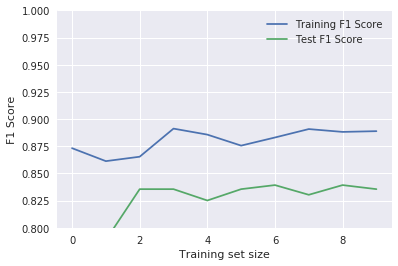

In [99]:
lr_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('Logistic Regression {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [lr_eval.values[i,0],lr_eval.values[i,1]] = logistic_regression(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(lr_eval['train'], lr_eval['test'])

## 2.2 K-Nearest Neighbors

In [92]:
from sklearn.neighbors import KNeighborsClassifier
def knn(X_train,y_train,X_test,y_test):
  classifier = KNeighborsClassifier(n_neighbors = 10, metric = 'minkowski', p = 2)
  classifier.fit(X_train, y_train)
  y_train_pred = classifier.predict(X_train)
  y_test_pred = classifier.predict(X_test)
  return evaluate(y_train_pred,y_train,y_test_pred,y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


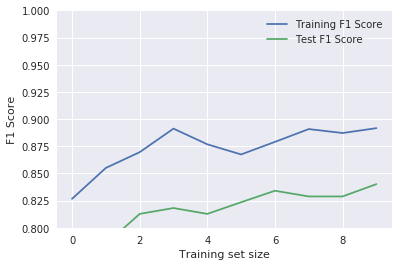

In [100]:
knn_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('KNN {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [knn_eval.values[i,0],knn_eval.values[i,1]] = knn(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(knn_eval['train'], knn_eval['test'])

## 2.3 Support Vector Machine

In [94]:
from sklearn.svm import SVC

def svm(X_train, y_train, X_test, y_test):
  classifier = SVC(kernel = 'rbf')
  classifier.fit(X_train, y_train)
  y_test_pred = classifier.predict(X_test)
  y_train_pred = classifier.predict(X_train)
  return evaluate(y_train_pred,y_train,y_test_pred,y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


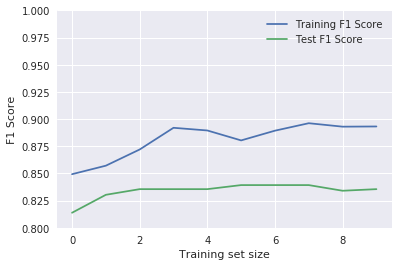

In [101]:
svm_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('SVM {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [svm_eval.values[i,0],svm_eval.values[i,1]] = svm(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(svm_eval['train'], svm_eval['test'])

## 2.4 Naives Bayes

In [96]:
from sklearn.naive_bayes import GaussianNB
  
def naive_bayes(X_train, y_train, X_test, y_test):
  classifier = GaussianNB()
  classifier.fit(X_train, y_train)
  y_test_pred = classifier.predict(X_test)
  y_train_pred = classifier.predict(X_train)
  return evaluate(y_train_pred,y_train,y_test_pred,y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


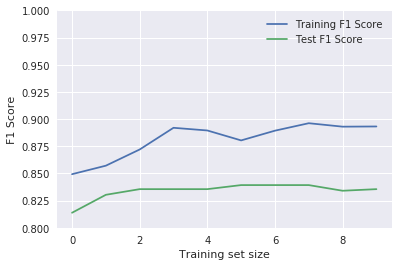

In [102]:
nb_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('Naives Bayes {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [nb_eval.values[i,0],nb_eval.values[i,1]] = svm(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(nb_eval['train'], nb_eval['test'])

## 2.5 Random Forest Classification

In [103]:
from sklearn.ensemble import RandomForestClassifier

def random_forest(X_train,y_train,X_test,y_test):
  classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy')
  classifier.fit(X_train, y_train)
  y_test_pred = classifier.predict(X_test)
  y_train_pred = classifier.predict(X_train)
  return evaluate(y_train_pred,y_train,y_test_pred,y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


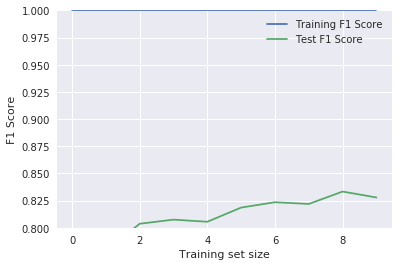

In [104]:
rf_eval = pd.DataFrame(0, index=range(10), columns=['train', 'test']).astype(float)

for i in range(10):
  print('Random Forest {}/10...'.format(i+1), end='\r')
  subset_size = int(round(((i+1)*X_train.shape[0]/10)))
  [rf_eval.values[i,0],rf_eval.values[i,1]] = random_forest(X_train[:subset_size,:], y_train[:subset_size], X_test, y_test)
  
show_results(rf_eval['train'], rf_eval['test'])

## 2.6 Deep Neural Network

In [118]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from time import time
from keras.callbacks import TensorBoard
from google.datalab.ml import TensorBoard as tb # if running from a Google Cloud Platform Datalab

def dnn(X_train,y_train,X_test,y_test):
  tensorboard = TensorBoard(log_dir='logs/bs3e100')
  classifier = Sequential()
  classifier.add(Dense(input_dim = 25, units = 50, activation = 'relu', kernel_initializer = 'uniform'))
  classifier.add(Dense(units = 25, activation = 'relu', kernel_initializer = 'uniform'))
  classifier.add(Dense(units = 10, activation = 'relu', kernel_initializer = 'uniform'))
  classifier.add(Dense(units = 1, activation = 'sigmoid', kernel_initializer = 'uniform'))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy')
  classifier.fit(X_train,y_train, batch_size = 3, epochs = 100, callbacks=[tensorboard], verbose=0)
  y_test_pred = classifier.predict(X_test)
  y_test_pred = (y_test_pred > 0.5)
  y_train_pred = classifier.predict(X_train)
  y_train_pred = (y_train_pred > 0.5)
  return evaluate(y_train_pred,y_train,y_test_pred,y_test)

/usr/local/envs/py3env/lib/python3.5/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


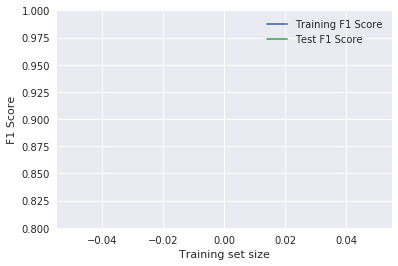

In [119]:
dnn_eval = pd.DataFrame(0, index=range(1), columns=['train', 'test']).astype(float)

[dnn_eval.values[0,0],dnn_eval.values[0,1]] = dnn(X_train, y_train, X_test, y_test)

In [27]:
tb.start('./logs') # Only start if it has not been started yet

TensorBoard was started successfully with pid 5510. Click here to access it.

5510

# Conclusion

In [120]:
print(lr_eval)
print(knn_eval)
print(svm_eval)
print(rf_eval)
print(dnn_eval)

      train      test
0  0.873239  0.753769
1  0.861314  0.788732
2  0.865385  0.835556
3  0.891228  0.835556
4  0.885714  0.825112
5  0.875598  0.835556
6  0.883065  0.839286
7  0.890815  0.830357
8  0.888199  0.839286
9  0.888889  0.835556
      train      test
0  0.826667  0.766667
1  0.855072  0.785047
2  0.869565  0.812785
3  0.891228  0.818182
4  0.876791  0.812785
5  0.867470  0.823529
6  0.879032  0.834081
7  0.890815  0.828829
8  0.887172  0.828829
9  0.891667  0.840183
      train      test
0  0.849315  0.813853
1  0.857143  0.830357
2  0.872038  0.835556
3  0.891986  0.835556
4  0.889518  0.835556
5  0.880383  0.839286
6  0.889336  0.839286
7  0.896194  0.839286
8  0.893023  0.834081
9  0.893204  0.835556
   train      test
0    1.0  0.688995
1    1.0  0.778846
2    1.0  0.803738
3    1.0  0.807512
4    1.0  0.805556
5    1.0  0.818605
6    1.0  0.823529
7    1.0  0.821918
8    1.0  0.833333
9    1.0  0.827907
      train      test
0  0.928367  0.788462
